<a href="https://colab.research.google.com/github/DataEtnos/Teste_previs-es_de_aluguel_2022/blob/main/previsao%20de%20aluguel%20em%20cidades%20do%20brasil%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [143]:
  #Setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots




#machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, StandardScaler
from sklearn import metrics
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import scale, minmax_scale, power_transform


#retirar avisos
import warnings

DADOS : https://www.kaggle.com/code/juniorbueno/brazilian-houses-rent-various-regressions

biblioteca nova : https://scikit--learn-org.translate.goog/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html?_x_tr_sl=auto&_x_tr_tl=pt&_x_tr_hl=pt-BR&_x_tr_pto=wapp#sklearn.ensemble.HistGradientBoostingRegressor


## Colunas da tabela:

city: Cidade em que o imóvel está localizado.

Área: A área do imóvel.

rooms: Quantidade de quartos do imóvel.

bathroom: Quantidade de banheiros do imóvel.

parking spaces: Quantidade de vagas de garagem do imóvel.

floor: Andar do imóvel.

animal: Se aceita animais.

furniture: Se é mobiliado.

hoa (R$): Valor da taxa de condominio (homeowners association tax), em reais.

rent amount (R$): Valor do aluguel, em reais.

property tax (R$): Valor do IPTU, em reais.

fire insurance (R$): Valor do seguro incêndio, em reais.

total (R$): Valor total (soma das 4 colunas anteriores), em reais.


In [144]:
# Subindo a base e verificando os dados
df = pd.read_csv('/content/houses_to_rent.csv')
df.head()
# Suprime todos os avisos
warnings.filterwarnings('ignore')

In [145]:
#pegando o nome das colunas para editar e fazer uma pequena limpeza
df.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor',
       'animal', 'furniture', 'hoa (R$)', 'rent amount (R$)',
       'property tax (R$)', 'fire insurance (R$)', 'total (R$)'],
      dtype='object')

In [146]:
#editando dados e retirando R$ dos nomes de colunas
df.rename(columns={"hoa (R$)": "hoa"}, inplace=True)
df.rename(columns={"property tax (R$)": "property_tax"}, inplace=True)
df.rename(columns={"fire insurance (R$)": "fire_insurance"}, inplace=True)
df.rename(columns={"total (R$)": "total"}, inplace=True)
df.rename(columns={"rent amount (R$)": "rent_amount"}, inplace=True)
df.rename(columns={"parking spaces": "parking_spaces"}, inplace=True)
df.head()

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [147]:
#puxando dados verificando o tipo de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   city            10692 non-null  object
 1   area            10692 non-null  int64 
 2   rooms           10692 non-null  int64 
 3   bathroom        10692 non-null  int64 
 4   parking_spaces  10692 non-null  int64 
 5   floor           10692 non-null  object
 6   animal          10692 non-null  object
 7   furniture       10692 non-null  object
 8   hoa             10692 non-null  int64 
 9   rent_amount     10692 non-null  int64 
 10  property_tax    10692 non-null  int64 
 11  fire_insurance  10692 non-null  int64 
 12  total           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


In [148]:
#retirando algumas metricas estatitcas como os quartil , media e devio padrão
df.describe()

,area,rooms,bathroom,parking_spaces,hoa,rent_amount,property_tax,fire_insurance,total
count,10692.000000,10692.000000,10692.000000,10692.000000,1.069200e+04,10692.000000,10692.000000,10692.000000,1.069200e+04
mean,149.217920,2.506079,2.236813,1.609147,1.174022e+03,3896.247194,366.704358,53.300879,5.490487e+03
std,537.016942,1.171266,1.407198,1.589521,1.559231e+04,3408.545518,3107.832321,47.768031,1.648473e+04
min,11.000000,1.000000,1.000000,0.000000,0.000000e+00,450.000000,0.000000,3.000000,4.990000e+02
25%,56.000000,2.000000,1.000000,0.000000,1.700000e+02,1530.000000,38.000000,21.000000,2.061750e+03
50%,90.000000,2.000000,2.000000,1.000000,5.600000e+02,2661.000000,125.000000,36.000000,3.581500e+03
75%,182.000000,3.000000,3.000000,2.000000,1.237500e+03,5000.000000,375.000000,68.000000,6.768000e+03
max,46335.000000,13.000000,10.000000,12.000000,1.117000e+06,45000.000000,313700.000000,677.000000,1.120000e+06


In [149]:
#verificando o tamanho dos dado
df.shape

(10692, 13)

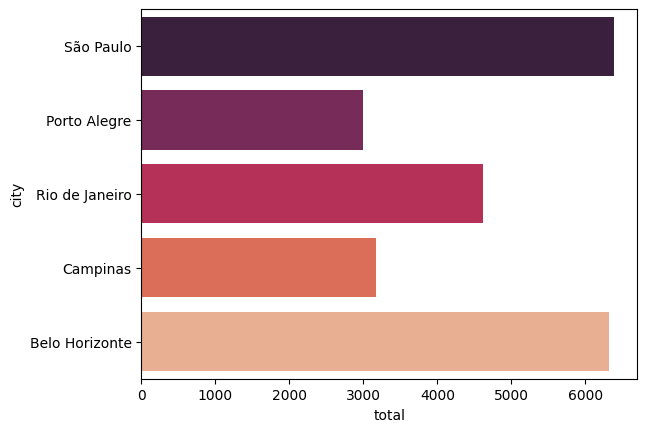

In [216]:
# fazendo as primeras analises ,  verificando qual cidade tem os alugueis mais caros
sns.barplot(x='total', y='city', data=df, orient='h', palette='rocket',ci=None);

verificando quais cidade tem o maiores valores totais   : sendo eles São Paulo e Belo Horizonte

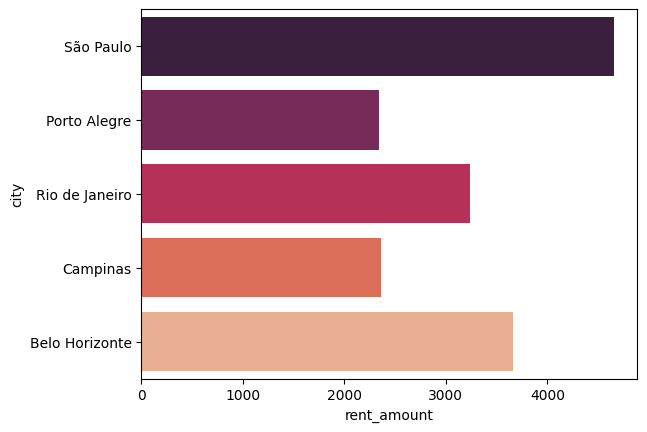

In [152]:
sns.barplot(x='rent_amount', y='city', data=df, orient='h', palette='rocket',ci=None);

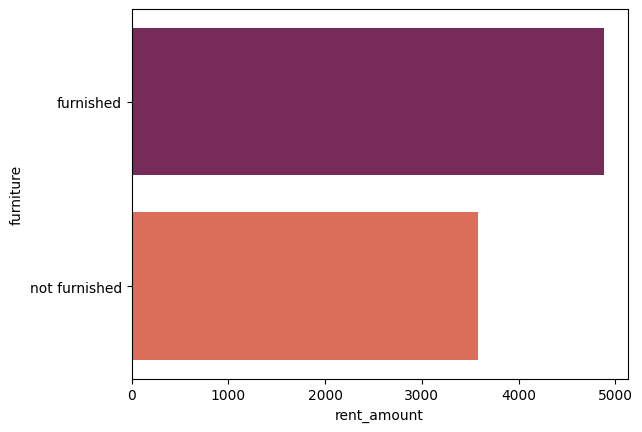

In [219]:
sns.barplot(x='rent_amount', y='furniture', data=df, orient='h', palette='rocket',ci=None);

In [154]:
# puxando novamente a coluna para fazer uma para transforma  variaveis categoricas em  0 e 1 ou mais . para mais tarde aplicar um modelo de machine learning de previsão de total.
df.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking_spaces', 'floor',
       'animal', 'furniture', 'hoa', 'rent_amount', 'property_tax',
       'fire_insurance', 'total'],
      dtype='object')

In [155]:
df.head()

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [156]:
# verifcando novamente os dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   city            10692 non-null  object
 1   area            10692 non-null  int64 
 2   rooms           10692 non-null  int64 
 3   bathroom        10692 non-null  int64 
 4   parking_spaces  10692 non-null  int64 
 5   floor           10692 non-null  object
 6   animal          10692 non-null  object
 7   furniture       10692 non-null  object
 8   hoa             10692 non-null  int64 
 9   rent_amount     10692 non-null  int64 
 10  property_tax    10692 non-null  int64 
 11  fire_insurance  10692 non-null  int64 
 12  total           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


In [157]:
df.head()



,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [158]:
df.head()

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [159]:
#função para contagem coluna a coluna de outliers
def is_outlier(array, extreme=False):

  q1,q3 = np.quantile(array, [.25,.75])
  iqr = q3-q1

  factor = 3. if extreme else 1.5
  upper_outlier = q3 + factor*iqr
  lower_outlier = q1 - factor*iqr

  return (array < lower_outlier) | (array > upper_outlier)

In [160]:
#contagem de outliers por area
is_outlier(df.area).sum()

672

In [161]:
#outliers por hoa
is_outlier(df.hoa).sum()

717

In [162]:
is_outlier(df.property_tax).sum()

1081

In [163]:
#outliers por total
is_outlier(df.total).sum()

706

Vi a necessidade de criar um outro data set setando valores de area e total para continuar as analises .  


Tendo em vista que outliers tendencia o centro de distribuição de dados , alteram o valor da media . vi a necessidade de setar valores para a variavel total  que será o target (alvo =  variavel resposta dos modelos de previsão que vou ultilizar nesse dataset )


In [164]:
df2 = df.query("total <=6000 & area <= 6000")

In [165]:
print(df.shape)
print(df2.shape)

(10692, 13)
(7576, 13)


In [166]:
df2.head()

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836
6,Rio de Janeiro,72,2,1,0,7,acept,not furnished,740,1900,85,25,2750


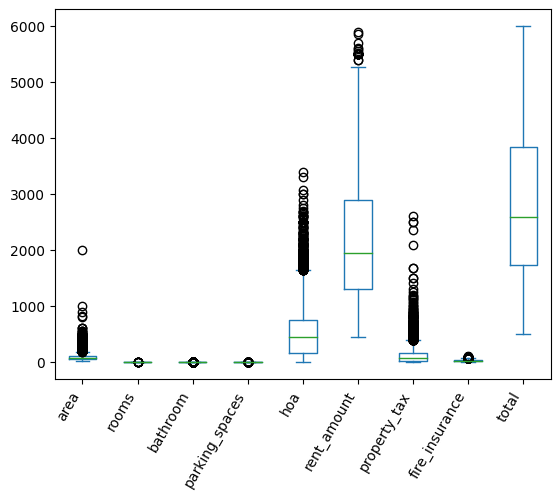

In [167]:
#padronizado
df2.plot.box()
plt.xticks(rotation=60, ha='right');

verificando novamente os dados para ver a como ficou depois que restringe para  6000 valor total do aluguel e area tambem para  6000.

In [168]:
#comparando tamanho dos dados
print(df.shape)
print(df2.shape)

(10692, 13)
(7576, 13)


In [169]:
X = df2.drop('rent_amount', axis=1)
y = df2['rent_amount']
lista_coluna= list(X.columns)
scaler = MinMaxScaler()

enconder = OrdinalEncoder()
X = enconder.fit_transform(X)
X = scaler.fit_transform(X)


In [170]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.3)

In [171]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7576 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   city            7576 non-null   object
 1   area            7576 non-null   int64 
 2   rooms           7576 non-null   int64 
 3   bathroom        7576 non-null   int64 
 4   parking_spaces  7576 non-null   int64 
 5   floor           7576 non-null   object
 6   animal          7576 non-null   object
 7   furniture       7576 non-null   object
 8   hoa             7576 non-null   int64 
 9   rent_amount     7576 non-null   int64 
 10  property_tax    7576 non-null   int64 
 11  fire_insurance  7576 non-null   int64 
 12  total           7576 non-null   int64 
dtypes: int64(9), object(4)
memory usage: 828.6+ KB


Com  este grafico de correlação verifico um pouco antesd de aplicar os modelos as colunnas que impactam entre si.  

por exemplo o valor total tem impactos de mudança de valor de acordo com o valor de rent_amount(aluguel) = 0.92 fire_insurance(seguro incendio)0.85 .


um outro exemplo a quantidade banheiros tem impacto de mudança apartir do valor de rooms(quartos) = 0.65 e area = 0.64

In [172]:
df2.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking_spaces', 'floor',
       'animal', 'furniture', 'hoa', 'rent_amount', 'property_tax',
       'fire_insurance', 'total'],
      dtype='object')

In [173]:
X_train

array([[0.5       , 0.14239482, 0.14285714, ..., 0.05545927, 0.07865169,
        0.04073873],
       [1.        , 0.0420712 , 0.        , ..., 0.        , 0.11235955,
        0.02064096],
       [0.        , 0.28478964, 0.28571429, ..., 0.31715771, 0.21348315,
        0.31558935],
       ...,
       [1.        , 0.13268608, 0.14285714, ..., 0.00866551, 0.14606742,
        0.19989136],
       [0.        , 0.38187702, 0.42857143, ..., 0.35701906, 0.35955056,
        0.54698533],
       [0.5       , 0.10679612, 0.        , ..., 0.        , 0.26966292,
        0.28598588]])

In [174]:
y_test.head(5)


,rent_amount
2733,2900
7646,3000
7578,3700
1801,3290
2785,2000


In [175]:
print(y_train.head())
y_train.info(

)

7660      637
8416      836
10452    1600
205      1250
1288     1600
Name: rent_amount, dtype: int64
<class 'pandas.core.series.Series'>
Index: 5303 entries, 7660 to 10251
Series name: rent_amount
Non-Null Count  Dtype
--------------  -----
5303 non-null   int64
dtypes: int64(1)
memory usage: 82.9 KB


In [176]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.5,0.142395,0.142857,0.000000,0.000000,0.800000,0.0,1.0,0.118250,0.055459,0.078652,0.040739
1,1.0,0.042071,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000,0.112360,0.020641
2,0.0,0.284790,0.285714,0.166667,0.222222,0.400000,0.0,1.0,0.146182,0.317158,0.213483,0.315589
3,1.0,0.187702,0.142857,0.000000,0.111111,0.000000,0.0,1.0,0.074488,0.086655,0.146067,0.169745
4,1.0,0.032362,0.000000,0.000000,0.000000,0.833333,0.0,1.0,0.215084,0.000000,0.202247,0.291146
...,...,...,...,...,...,...,...,...,...,...,...,...
5298,1.0,0.268608,0.142857,0.000000,0.111111,0.233333,0.0,1.0,0.584730,0.116118,0.404494,0.702879
5299,1.0,0.135922,0.142857,0.000000,0.111111,0.700000,0.0,1.0,0.474860,0.145581,0.146067,0.292776
5300,1.0,0.132686,0.142857,0.166667,0.111111,0.900000,1.0,1.0,0.195531,0.008666,0.146067,0.199891
5301,0.0,0.381877,0.428571,0.333333,0.111111,0.033333,0.0,1.0,0.155493,0.357019,0.359551,0.546985


In [210]:
gbr = GradientBoostingRegressor(
    random_state=42
)
gbr.fit(X_train, y_train)


predit = gbr.predict(X_test)
erro = abs(predit - y_test)


gbr.score(X_train, y_train)

#RESULTADO
print('R2:', gbr.score(X_train, y_train))
print('MAE:', metrics.mean_absolute_error(y_test, predit))
print('MSE:', metrics.mean_squared_error(y_test, predit))

R2: 0.9952079131816374
MAE: 51.93538923497074
MSE: 8047.265594415645


In [178]:
#descobrindo quais colunas do data set tem maior peso nos resultado
# E verificando se nao tivemos vazamento de resultados

importances = list(gbr.feature_importances_)

features_importance = [(features,round(importance, 2)) for features, importance in zip(lista_coluna, gbr.feature_importances_)]
features_importance = sorted(features_importance, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in features_importance]

Variable: fire_insurance       Importance: 0.81
Variable: total                Importance: 0.18
Variable: city                 Importance: 0.0
Variable: area                 Importance: 0.0
Variable: rooms                Importance: 0.0
Variable: bathroom             Importance: 0.0
Variable: parking_spaces       Importance: 0.0
Variable: floor                Importance: 0.0
Variable: animal               Importance: 0.0
Variable: furniture            Importance: 0.0
Variable: hoa                  Importance: 0.0
Variable: property_tax         Importance: 0.0


[None, None, None, None, None, None, None, None, None, None, None, None]

In [179]:
ada = AdaBoostRegressor(random_state=42)
ada.fit(X_train, y_train)


predit_a = ada.predict(X_test)
erro = abs(predit - y_test)

#RESULTADO
print('R2:', ada.score(X_train, y_train))
print('MAE:', metrics.mean_absolute_error(y_test, predit_a))
print('MSE:', metrics.mean_squared_error(y_test, predit_a))

R2: 0.966808404112244
MAE: 168.33811397163495
MSE: 46619.70398983143


In [180]:
#descobrindo quais colunas do data set tem maior peso nos resultado
# E verificando se nao tivemos vazamento de resultados

importances = list(ada.feature_importances_)

features_importance = [(features,round(importance, 2)) for features, importance in zip(lista_coluna, ada.feature_importances_)]
features_importance = sorted(features_importance, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in features_importance]

Variable: fire_insurance       Importance: 0.47
Variable: total                Importance: 0.39
Variable: hoa                  Importance: 0.1
Variable: property_tax         Importance: 0.03
Variable: city                 Importance: 0.01
Variable: area                 Importance: 0.0
Variable: rooms                Importance: 0.0
Variable: bathroom             Importance: 0.0
Variable: parking_spaces       Importance: 0.0
Variable: floor                Importance: 0.0
Variable: animal               Importance: 0.0
Variable: furniture            Importance: 0.0


[None, None, None, None, None, None, None, None, None, None, None, None]

In [181]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)


predit_r = rf.predict(X_test)
erro = abs(predit_r - y_test)

#RESULTADO
print('R2:', rf.score(X_train, y_train))
print('MAE:', metrics.mean_absolute_error(y_test, predit_r))
print('MSE:', metrics.mean_squared_error(y_test, predit_r))

R2: 0.9986801710683959
MAE: 38.658979322481294
MSE: 10347.384609678838


In [182]:
#descobrindo quais colunas do data set tem maior peso nos resultado
# E verificando se nao tivemos vazamento de resultados

importances = list(rf.feature_importances_)

features_importance = [(features,round(importance, 2)) for features, importance in zip(lista_coluna, rf.feature_importances_)]
features_importance = sorted(features_importance, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in features_importance]

Variable: fire_insurance       Importance: 0.95
Variable: total                Importance: 0.04
Variable: city                 Importance: 0.0
Variable: area                 Importance: 0.0
Variable: rooms                Importance: 0.0
Variable: bathroom             Importance: 0.0
Variable: parking_spaces       Importance: 0.0
Variable: floor                Importance: 0.0
Variable: animal               Importance: 0.0
Variable: furniture            Importance: 0.0
Variable: hoa                  Importance: 0.0
Variable: property_tax         Importance: 0.0


[None, None, None, None, None, None, None, None, None, None, None, None]

In [183]:
from sklearn.ensemble import HistGradientBoostingRegressor

HistGradientBoostingRegressor(random_state=42)
est = HistGradientBoostingRegressor().fit(X, y)
predit = est.predict(X_test)
erro = abs(predit - y_test)
est.score(X, y)

#RESULTADO
print('R2:', est.score(X_test, y_test))
print('MAE:', metrics.mean_absolute_error(y_test, predit))
print('MSE:', metrics.mean_squared_error(y_test, predit))

R2: 0.9985318399974176
MAE: 24.78296080461022
MSE: 1628.9299087180518


In [186]:
parameters = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7]
}


grid_search = GridSearchCV(gbr, parameters,scoring = 'r2',cv=5,n_jobs = -1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='r2')

In [188]:
grid_search.best_estimator_.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [201]:
gbr = GradientBoostingRegressor(
alpha= 0.9,
 ccp_alpha= 0.0,
 criterion= 'friedman_mse',
 init= None,
 learning_rate = 0.1,
 loss = 'squared_error',
 max_depth=3,
 max_features= None,
 max_leaf_nodes=None,
 min_impurity_decrease= 0.0,
 min_samples_leaf= 1,
 min_samples_split=2,
 min_weight_fraction_leaf= 0.0,
 n_estimators =300,
 n_iter_no_change = None,
 random_state= 42,
 subsample=1.0,
 tol= 0.0001,
 validation_fraction= 0.1,
 verbose= 0,
 warm_start=False
)
gbr.fit(X_train, y_train)


predit = gbr.predict(X_test)
erro = abs(predit - y_test)


gbr.score(X_train, y_train)
#RESULTADO
print(f'R2: {gbr.score(X_train, y_train):.3f}%')
print(f'MAE: {metrics.mean_absolute_error(y_test, predit):.3}%')
print(f'MSE: {metrics.mean_squared_error(y_test, predit)}%')

R2: 0.998%
MAE: 35.9%
MSE: 4545.049160571305%


In [213]:
parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}



grid_search = GridSearchCV(rf, parameters,scoring = 'r2',cv=5,n_jobs = -1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='r2')

In [214]:
grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [215]:
rf = RandomForestRegressor(
bootstrap= True,
 ccp_alpha= 0.0,
 criterion= 'squared_error',
 max_depth= 7,
 max_features=1.0,
 max_leaf_nodes= None,
 max_samples =None,
 min_impurity_decrease= 0.0,
 min_samples_leaf= 1,
 min_samples_split =2,
 min_weight_fraction_leaf= 0.0,
 n_estimators =100,
 n_jobs =None,
 oob_score= False,
 random_state =42,
 verbose= 0,
 warm_start =False)


rf.fit(X_train, y_train)


predit_r = rf.predict(X_test)
erro = abs(predit_r - y_test)

#RESULTADO
print('R2:', rf.score(X_train, y_train))
print('MAE:', metrics.mean_absolute_error(y_test, predit_r))
print('MSE:', metrics.mean_squared_error(y_test, predit_r))

R2: 0.9932848446584148
MAE: 64.11769486000101
MSE: 14778.733040146572


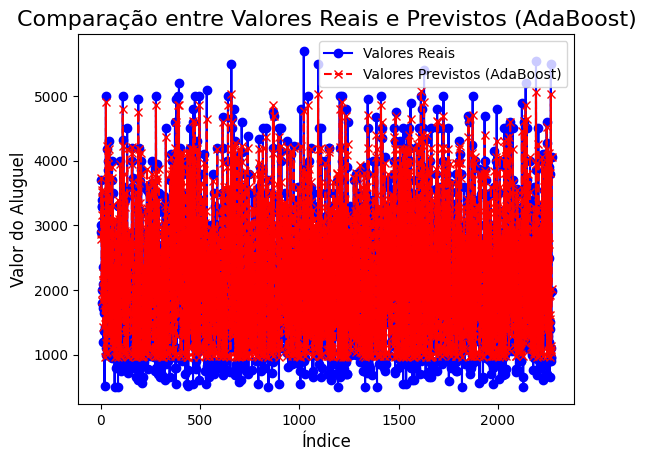

In [221]:
plt.plot(range(len(y_test)), y_test, label='Valores Reais', color='blue', linestyle='-', marker='o')

# Plotando os valores previstos (predit_a)
plt.plot(range(len(predit_a)), predit_a, label='Valores Previstos (AdaBoost)', color='red', linestyle='--', marker='x')

# Adicionando título e rótulos
plt.title('Comparação entre Valores Reais e Previstos (AdaBoost)', fontsize=16)
plt.xlabel('Índice', fontsize=12)
plt.ylabel('Valor do Aluguel', fontsize=12)

# Exibindo a legenda
plt.legend()

# Exibindo o gráfico
plt.show()

O histgradient boosting nao fornece as features importance , pois e um modelo de analises rapida .  

Após concluir este estudo, fico com o resultado do AdaBoost.

Pelos seguintes motivos:

Utilizei várias bibliotecas, como Gradient Boosting, Random Forest e AdaBoost, que indicam que a feature (coluna) mais importante para definir o valor de rent_amount é a fire_insurance. Apesar disso fazer sentido, o modelo mais simples sugere que outras variáveis também podem justificar o valor de rent_amount.

Suspeito que o R² de 99% seja exagerado, mesmo considerando as importâncias das features. Uma faixa de 96%, utilizando as colunas que realmente são relevantes para o modelo sem tendenciá-lo, parece mais realista e um pouco mais conservador .










